https://zhuanlan.zhihu.com/p/45964374

# QR分解

Running on cuda


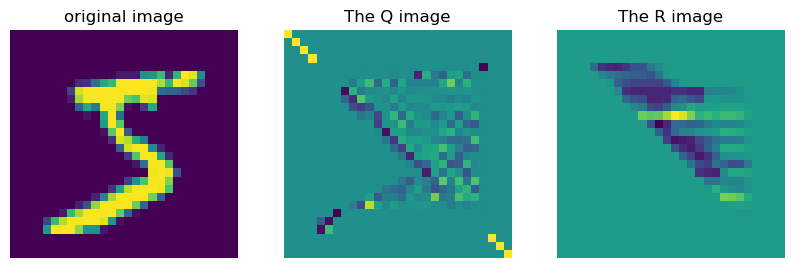

In [1]:
import torchvision
from torchvision import models, datasets, transforms
import torch
# 加载CIFAR-10数据集，如果本地没有则自动下载
dst = datasets.MNIST("~/data", download=True)
# dst = datasets.CIFAR10("~/data", download=True)

# 定义一个转换序列，包括缩放、裁剪、转换为张量等操作
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

# 定义一个函数，用于将张量转换为PIL图像
tt = transforms.ToPILImage()

# 检测是否有可用的GPU，如果有则使用GPU，否则使用CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# 定义一个函数，用于将标签转换为one-hot编码的张量
def label_to_onehot(target, num_classes=10):
    # 在第一个维度上增加一个维度，使得target的形状为(N, 1)
    target = torch.unsqueeze(target, 1)
    # 创建一个全零的张量，形状为(N, num_classes)，设备与target相同
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    # 在第二个维度上根据target的值将onehot_target的对应位置设为1
    onehot_target.scatter_(1, target, 1)
    # 返回onehot_target
    return onehot_target

# 导入所需的库
import numpy as np
from sklearn import datasets
# 对数据集进行QR分解
img_index = 0 # 定义一个图像索引，表示要显示的图像在数据集中的位置
gt_data = dst[img_index][0] # 从数据集中获取图像，并使用之前定义的转换序列处理图像

Q, R =  np.linalg.qr(gt_data, mode = 'complete')

# 显示原始图片和压缩后的图片
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(gt_data)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(Q)
plt.title('The Q image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(R)
plt.title('The R image')
plt.axis('off')
plt.show()

In [2]:
from PIL import Image
img_k = Image.fromarray(Q.astype('uint8'))

In [3]:
# gt_data = tp(img_k).to(device) # 从数据集中获取图像，并使用之前定义的转换序列处理图像
# gt_data = gt_data.view(1, *gt_data.size())  # 将图像的形状调整为(1, 3, 32, 32)，表示批量大小为1，通道数为3，高度和宽度为32
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device) # 从数据集中获取图像的标签，并转换为长整型张量
gt_label = gt_label.view(1, ) # 将标签的形状调整为(1,)，表示批量大小为1
gt_onehot_label = label_to_onehot(gt_label, num_classes=10) # 将标签转换为one-hot编码的张量，形状为(1, 10)，表示批量大小为1，类别数为10
gt_data.requires_grad = True # 设置图像的梯度属性为True，表示可以对图像进行梯度计算

GT label is 5. 
Onehot label is 5.


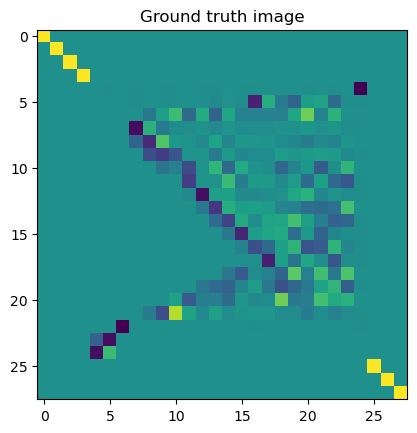

In [83]:
plt.imshow(Q) # 将图像从张量转换为PIL图像，并使用matplotlib显示图像
plt.title("Ground truth image") # 设置图像的标题为"Ground truth image"
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." %
      torch.argmax(gt_onehot_label, dim=-1).item()) # 打印图像的标签和one-hot编码的标签

# SVD用于图片压缩

## Soteria

In [ ]:
import torchvision
from torchvision import models, datasets, transforms
import torch
# 加载CIFAR-10数据集，如果本地没有则自动下载
dst = datasets.CIFAR10("~/data", download=True)

# 定义一个转换序列，包括缩放、裁剪、转换为张量等操作
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

# 定义一个函数，用于将张量转换为PIL图像
tt = transforms.ToPILImage()

# 检测是否有可用的GPU，如果有则使用GPU，否则使用CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# 定义一个函数，用于将标签转换为one-hot编码的张量
def label_to_onehot(target, num_classes=10):
    # 在第一个维度上增加一个维度，使得target的形状为(N, 1)
    target = torch.unsqueeze(target, 1)
    # 创建一个全零的张量，形状为(N, num_classes)，设备与target相同
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    # 在第二个维度上根据target的值将onehot_target的对应位置设为1
    onehot_target.scatter_(1, target, 1)
    # 返回onehot_target
    return onehot_target

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_index = 26 # 定义一个图像索引，表示要显示的图像在数据集中的位置

gt_data = dst[img_index][0] # 从数据集中获取图像，并使用之前定义的转换序列处理图像
img_array = np.array(gt_data)

# 分离三个颜色通道
R = img_array[:, :, 0]
G = img_array[:, :, 1]
B = img_array[:, :, 2]

# 定义一个函数，用SVD对单通道矩阵进行压缩
def compress_channel(channel, k):
    # 对单通道矩阵进行SVD分解
    U, S, V = np.linalg.svd(channel)
    # 取前k个奇异值和对应的左右奇异向量
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    # 用前k个奇异值和奇异向量重构单通道矩阵
    channel_k = np.dot(U_k, np.dot(S_k, V_k))
    # 将重构后的矩阵元素值限制在0-255之间
    channel_k = np.clip(channel_k, 0, 255)
    # 返回压缩后的单通道矩阵
    return channel_k

# 定义一个参数，表示要保留的奇异值的个数
k = 3

# 对每个颜色通道进行压缩
R_k = compress_channel(R, k)
G_k = compress_channel(G, k)
B_k = compress_channel(B, k)

# 将压缩后的三个颜色通道合并为一个三维数组
img_array_k = np.stack((R_k, G_k, B_k), axis=2)

# 将压缩后的数组转换为图片
img_k = Image.fromarray(img_array_k.astype('uint8'))

# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gt_data)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_k)
plt.title('The compressed image')
plt.axis('off')
plt.show()

In [ ]:
# 导入必要的库
import numpy as np
from sklearn.decomposition import TruncatedSVD

gt_data = dst[img_index][0]
img_array=np.array(gt_data)

# 分离三个颜色通道
R = img_array[:, :, 0]
G = img_array[:, :, 1]
B = img_array[:, :, 2]

In [ ]:
#  Image.fromarray(R)
plt.imshow(R)

## PSNR

高于40dB：说明图像质量极好（即非常接近原始图像）

30—40dB：通常表示图像质量是好的（即失真可以察觉但可以接受）

20—30dB：说明图像质量差

低于20dB：图像质量不可接受

In [ ]:
# 定义一个函数，计算两张图片的PSNR
def psnr(img1, img2):
    # 将图片转换为numpy数组
    img1 = np.array(img1)
    img2 = np.array(img2)
    # 计算两张图片的均方误差
    mse = np.mean((img1 - img2) ** 2)
    # 计算两张图片的最大像素值
    max_pixel = 255
    # 计算并返回PSNR
    return 10 * np.log10(max_pixel ** 2 / mse)

# 将压缩后的数组转换为图片
img_k = Image.fromarray(img_array_k.astype('uint8'))

# 计算原始图片和压缩后图片的PSNR
psnr_value = psnr(gt_data, img_k)
print(f'PSNR = {psnr_value:.2f} dB')

In [ ]:
gt_data = tp(img_k).to(device) # 从数据集中获取图像，并使用之前定义的转换序列处理图像
gt_data = gt_data.view(1, *gt_data.size())  # 将图像的形状调整为(1, 3, 32, 32)，表示批量大小为1，通道数为3，高度和宽度为32
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device) # 从数据集中获取图像的标签，并转换为长整型张量
gt_label = gt_label.view(1, ) # 将标签的形状调整为(1,)，表示批量大小为1
gt_onehot_label = label_to_onehot(gt_label, num_classes=10) # 将标签转换为one-hot编码的张量，形状为(1, 10)，表示批量大小为1，类别数为10
gt_data.requires_grad = True # 设置图像的梯度属性为True，表示可以对图像进行梯度计算

plt.imshow(tt(gt_data[0].cpu())) # 将图像从张量转换为PIL图像，并使用matplotlib显示图像
plt.title("Ground truth image") # 设置图像的标题为"Ground truth image"
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." %
      torch.argmax(gt_onehot_label, dim=-1).item()) # 打印图像的标签和one-hot编码的标签

## 压缩彩色图片

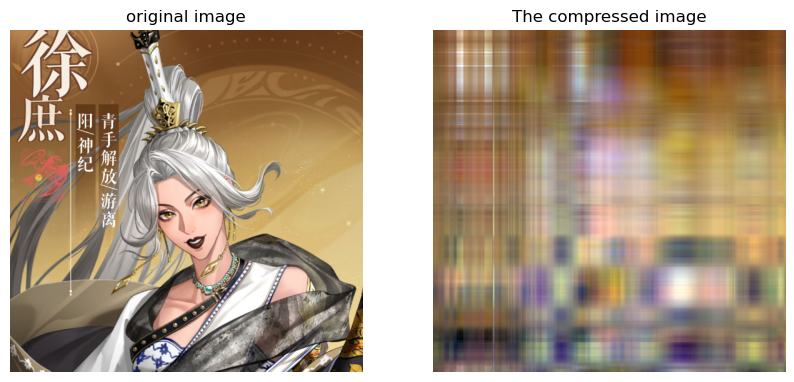

In [47]:
# 导入必要的库
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 读取图片并转换为numpy数组
img = Image.open('1.png')
img_array = np.array(img)

# 分离四个颜色通道
R = img_array[:, :, 0]
G = img_array[:, :, 1]
B = img_array[:, :, 2]
# A = img_array[:, :, 3]

# 定义一个函数，用SVD对单通道矩阵进行压缩
def compress_channel(channel, k):
    # 对单通道矩阵进行SVD分解
    U, S, V = np.linalg.svd(channel)
    # 取前k个奇异值和对应的左右奇异向量
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    # 用前k个奇异值和奇异向量重构单通道矩阵
    channel_k = np.dot(U_k, np.dot(S_k, V_k))
    # 将重构后的矩阵元素值限制在0-255之间
    channel_k = np.clip(channel_k, 0, 255)
    # 返回压缩后的单通道矩阵
    return channel_k

# 定义一个参数，表示要保留的奇异值的个数
k = 3

# 对每个颜色通道进行压缩
R_k = compress_channel(R, k)
G_k = compress_channel(G, k)
B_k = compress_channel(B, k)
# A_k = compress_channel(A, k)

# 将压缩后的四个颜色通道合并为一个三维数组
img_array_k = np.stack((R_k, G_k, B_k), axis=2)

# 将压缩后的数组转换为图片
img_k = Image.fromarray(img_array_k.astype('uint8'))

# 设置显示中文字体
plt.rcParams["font.sans-serif"] = ["SimHei"]
# 解决中文字体下坐标轴负数的负号显示问题
plt.rcParams["axes.unicode_minus"] = False

# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_k)
plt.title('The compressed image')
plt.axis('off')
plt.show()

## MNIST

In [37]:
U, S, V = np.linalg.svd(img_array)

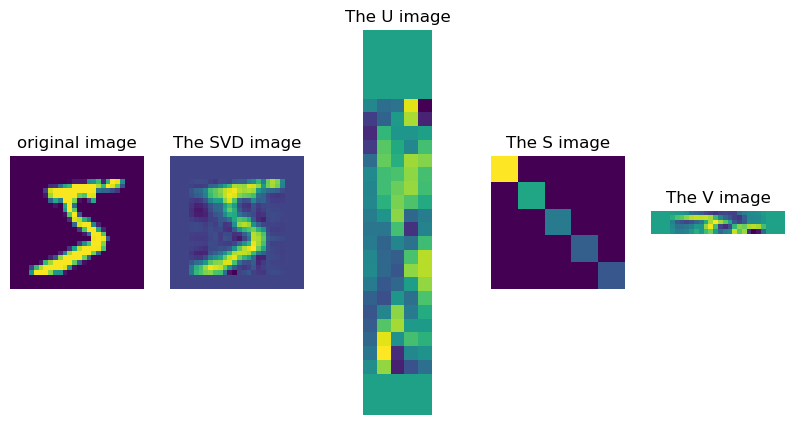

In [51]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.datasets as datasets

# 加载CIFAR10数据集
cifar10 = datasets.MNIST(root='~/data', train=True, download=True)
# 选择一张图片
img, label = cifar10[0]
# 转换为numpy数组
img_array = np.array(img)

# 定义一个函数，用SVD对单通道矩阵进行压缩
def compress_channel(channel, k):
    # 对单通道矩阵进行SVD分解
    U, S, V = np.linalg.svd(channel)
    # 取前k个奇异值和对应的左右奇异向量
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    # 用前k个奇异值和奇异向量重构单通道矩阵
    channel_k = np.dot(U_k, np.dot(S_k, V_k))
    # 将重构后的矩阵元素值限制在0-255之间
#     channel_k = np.clip(channel_k, 0, 255)
    # 返回压缩后的单通道矩阵
    return channel_k,U_k,S_k,V_k

# 定义一个参数，表示要保留的奇异值的个数
k = 5

# 对每个颜色通道进行压缩
img_k,U_k,S_k,V_k = compress_channel(img_array, k)

# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(img_k)
plt.title('The SVD image')
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(U_k)
plt.title('The U image')
plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(S_k)
plt.title('The S image')
plt.axis('off')
plt.subplot(1, 5, 5)
plt.imshow(V_k)
plt.title('The V image')
plt.axis('off')
plt.show()

## CIFAR10

In [ ]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.datasets as datasets

# 加载CIFAR10数据集
cifar10 = datasets.CIFAR10(root='~/data', train=True, download=True)
# 选择一张图片
img, label = cifar10[0]
# 转换为numpy数组
img_array = np.array(img)

# 分离三个颜色通道
R = img_array[:, :, 0]
G = img_array[:, :, 1]
B = img_array[:, :, 2]

# 定义一个函数，用SVD对单通道矩阵进行压缩
def compress_channel(channel, k):
    # 对单通道矩阵进行SVD分解
    U, S, V = np.linalg.svd(channel)
    # 取前k个奇异值和对应的左右奇异向量
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    # 用前k个奇异值和奇异向量重构单通道矩阵
    channel_k = np.dot(U_k, np.dot(S_k, V_k))
    # 将重构后的矩阵元素值限制在0-255之间
    channel_k = np.clip(channel_k, 0, 255)
    # 返回压缩后的单通道矩阵
    return channel_k

# 定义一个参数，表示要保留的奇异值的个数
k = 30

# 对每个颜色通道进行压缩
R_k = compress_channel(R, k)
G_k = compress_channel(G, k)
B_k = compress_channel(B, k)

# 将压缩后的三个颜色通道合并为一个三维数组
img_array_k = np.stack((R_k, G_k, B_k), axis=2)

# 将压缩后的数组转换为图片
img_k = Image.fromarray(img_array_k.astype('uint8'))

# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_k)
plt.title('The compressed image')
plt.axis('off')
plt.show()

# 模型训练

Epoch 1, Batch 200, Loss: 2.299
Epoch 1, Train Accuracy: 0.127
Epoch 1, Test Accuracy: 0.608
Epoch 2, Batch 200, Loss: 2.279
Epoch 2, Train Accuracy: 0.161
Epoch 2, Test Accuracy: 0.788
Epoch 3, Batch 200, Loss: 2.273
Epoch 3, Train Accuracy: 0.168
Epoch 3, Test Accuracy: 0.811
Epoch 4, Batch 200, Loss: 2.261
Epoch 4, Train Accuracy: 0.179
Epoch 4, Test Accuracy: 0.834
Epoch 5, Batch 200, Loss: 2.261
Epoch 5, Train Accuracy: 0.180
Epoch 5, Test Accuracy: 0.864


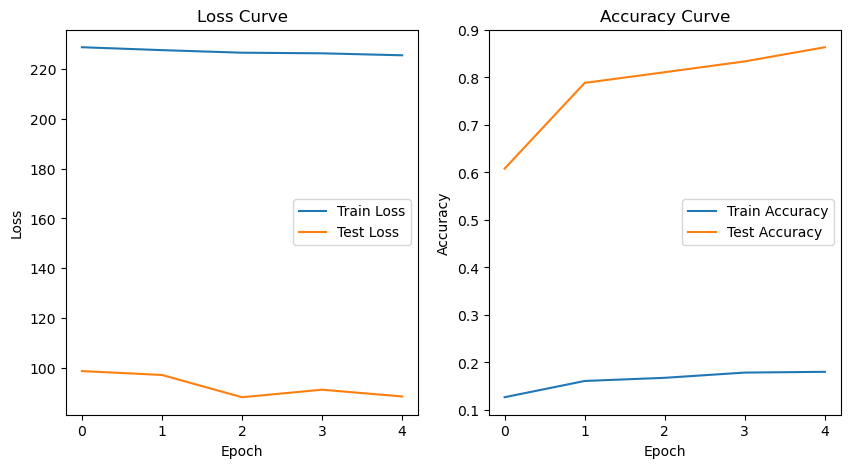

<All keys matched successfully>

In [4]:
# 导入必要的模块
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 定义数据转换和标准化
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))]
)

# 下载并加载MNIST数据集
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True, num_workers=0)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, shuffle=False, num_workers=0)

# 定义LeNet模型
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # 输入通道为1，输出通道为6，卷积核大小为5
        self.pool = nn.MaxPool2d(2, 2) # 池化层，窗口大小为2，步长为2
        self.conv2 = nn.Conv2d(6, 16, 5) # 输入通道为6，输出通道为16，卷积核大小为5
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # 全连接层，输入维度为16*4*4，输出维度为120
        self.fc2 = nn.Linear(120, 84) # 全连接层，输入维度为120，输出维度为84
        self.fc3 = nn.Linear(84, 10) # 全连接层，输入维度为84，输出维度为10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 第一层卷积后激活和池化
        x = self.pool(torch.relu(self.conv2(x))) # 第二层卷积后激活和池化
        x = x.view(-1, 16 * 4 * 4) # 将二维特征图展平为一维向量
        x = torch.relu(self.fc1(x)) # 第一层全连接后激活
        x = torch.relu(self.fc2(x)) # 第二层全连接后激活
        x = self.fc3(x) # 第三层全连接
        return x

# 创建模型实例
net = LeNet()

# 定义损失函数和优化器
loss_function = nn.CrossEntropyLoss() # 交叉熵损失函数，适用于多分类问题
optimizer = optim.Adam(net.parameters(), lr=0.001) # Adam优化器，适用于多种场景

# 定义训练的轮数
epochs = 5

# 定义列表，用于存储训练过程中的损失和准确率
train_loss_list = [] # 训练损失
train_acc_list = [] # 训练准确率
test_loss_list = [] # 测试损失
test_acc_list = [] # 测试准确率

# 训练模型
for epoch in range(epochs):
    # 初始化训练损失和准确率
    train_loss = 0.0
    train_acc = 0.0
    # 遍历训练集的每个批次
    for i, data in enumerate(train_loader):
        # 获取输入数据和标签
        inputs, labels = data
        # 对输入数据进行QR分解，得到Q矩阵
        print(inputs.shape)
        Q, R = torch.qr(inputs.view(-1, 28*28))
        # 将Q矩阵恢复为原始的形状
        Q = R.view(-1, 1, 28, 28)
        # 清零优化器的梯度
        optimizer.zero_grad()
        # 前向传播，得到输出
        outputs = net(Q)
        # 计算损失
        loss = loss_function(outputs, labels)
        # 反向传播，更新梯度
        loss.backward()
        # 更新参数
        optimizer.step()
        # 累加损失
        train_loss += loss.item()
        # 计算预测的类别
        _, predicted = torch.max(outputs, 1)
        # 累加正确的预测数
        train_acc += (predicted == labels).sum().item()
        # 每200个批次打印一次日志信息
        if (i + 1) % 200 == 0:
            print('Epoch %d, Batch %d, Loss: %.3f' % (epoch + 1, i + 1, train_loss / 200))
            # 重置训练损失
            train_loss = 0.0
    # 计算并打印该轮的训练准确率
    train_acc = train_acc / len(train_set)
    print('Epoch %d, Train Accuracy: %.3f' % (epoch + 1, train_acc))
    # 将训练损失和准确率添加到列表中
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # 初始化测试损失和准确率
    test_loss = 0.0
    test_acc = 0.0
    # 关闭梯度计算，节省内存
    with torch.no_grad():
        # 遍历测试集的每个批次
        for data in test_loader:
            # 获取输入数据和标签
            inputs, labels = data
            # 对输入数据进行QR分解，得到Q矩阵
            Q, R = torch.qr(inputs.view(-1, 28*28))
            # 将Q矩阵恢复为原始的形状
            Q = R.view(-1, 1, 28, 28)
            # 前向传播，得到输出
            outputs = net(inputs)
            # 计算损失
            loss = loss_function(outputs, labels)
            # 累加损失
            test_loss += loss.item()
            # 计算预测的类
                        # 计算预测的类别
            _, predicted = torch.max(outputs, 1)
            # 累加正确的预测数
            test_acc += (predicted == labels).sum().item()
        # 计算并打印该轮的测试准确率
        test_acc = test_acc / len(test_set)
        print('Epoch %d, Test Accuracy: %.3f' % (epoch + 1, test_acc))
        # 将测试损失和准确率添加到列表中
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

# 绘制损失和准确率的曲线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# 保存模型的参数
torch.save(net.state_dict(), 'lenet.pth')

# 加载模型的参数
net.load_state_dict(torch.load('lenet.pth'))

# KSVD

K-SVD算法是一种基于稀疏表示的字典学习方法，它可以用于图像去噪、压缩感知、特征提取等领域。

K-SVD算法的基本思想是，给定一个样本矩阵 Y ，寻找一个字典矩阵 D 和一个稀疏矩阵 X ，使得 Y ≈ DX ，同时 X 的非零元素尽可能少。

K-SVD算法的核心是交替地更新 D 和 X ，其中 D 的每一列称为一个原子，表示一个基向量， X 的每一行表示一个原子的系数。

更新 D 的过程是逐列地对每个原子和对应的系数进行奇异值分解（SVD），并取最大奇异值对应的向量作为新的原子和系数。

更新 X 的过程是利用正交匹配追踪（OMP）算法，对每个样本进行稀疏编码，即求解一个 L0 范数约束的最小二乘问题。

下面是一个用Python实现K-SVD算法的示例代码，您可以参考一下。

In [2]:
import numpy as np
from sklearn import linear_model
import scipy.misc
from matplotlib import pyplot as plt

class KSVD(object):
    def __init__(self, n_components, max_iter=30, tol=1e-6, n_nonzero_coefs=None):
        """
        稀疏模型Y = DX，Y为样本矩阵，使用KSVD动态更新字典矩阵D和稀疏矩阵X
        :param n_components: 字典所含原子个数（字典的列数）
        :param max_iter: 最大迭代次数
        :param tol: 稀疏表示结果的容差
        :param n_nonzero_coefs: 稀疏度
        """
        self.dictionary = None
        self.sparsecode = None
        self.max_iter = max_iter
        self.tol = tol
        self.n_components = n_components
        self.n_nonzero_coefs = n_nonzero_coefs

    def _initialize(self, y):
        """
        初始化字典矩阵
        """
        u, s, v = np.linalg.svd(y)
        self.dictionary = u[:, :self.n_components]

    def _update_dict(self, y, d, x):
        """
        使用KSVD更新字典的过程
        """
        for i in range(self.n_components):
            index = np.nonzero(x[i, :])[0]
            if len(index) == 0:
                continue
            d[:, i] = 0
            r = (y - np.dot(d, x))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            d[:, i] = u[:, 0].T
            x[i, index] = s[0] * v[0, :]
        return d, x

    def fit(self, y):
        """
        KSVD迭代过程
        """
        self._initialize(y)
        for i in range(self.max_iter):
            x = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)
            e = np.linalg.norm(y - np.dot(self.dictionary, x))
            if e < self.tol:
                break
            self._update_dict(y, self.dictionary, x)
        self.sparsecode = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)
        return self.dictionary, self.sparsecode

In [87]:
im_ascent = scipy.misc.ascent().astype(np.float64)
im_ascent

array([[ 83.,  83.,  83., ..., 117., 117., 117.],
       [ 82.,  82.,  83., ..., 117., 117., 117.],
       [ 80.,  81.,  83., ..., 117., 117., 117.],
       ...,
       [178., 178., 178., ...,  57.,  59.,  57.],
       [178., 178., 178., ...,  56.,  57.,  57.],
       [178., 178., 178., ...,  57.,  57.,  58.]])

In [89]:
ksvd = KSVD(30)
dictionary, sparsecode = ksvd.fit(im_ascent)

In [94]:
dictionary.shape

(512, 30)

In [93]:
sparsecode.shape

(30, 512)

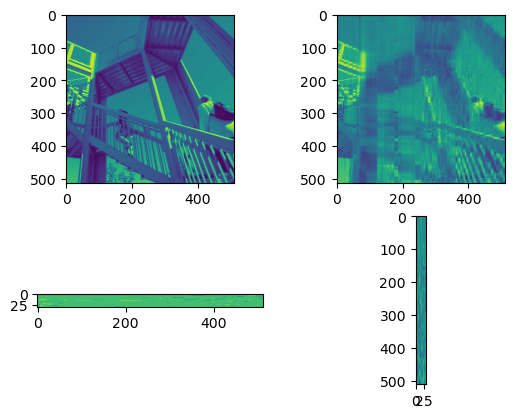

In [97]:
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(im_ascent)
plt.subplot(2, 2, 2)
plt.imshow(dictionary.dot(sparsecode))
plt.subplot(2,2, 3)
plt.imshow(sparsecode)
plt.subplot(2, 2, 4)
plt.imshow(dictionary)
plt.show()

## MNIST

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dict

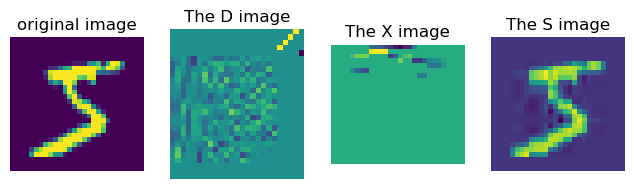

In [6]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.datasets as datasets

# 加载CIFAR10数据集
cifar10 = datasets.MNIST(root='~/data', train=True, download=True)
# 选择一张图片
img, label = cifar10[0]
# 转换为numpy数组
img_array = np.array(img)

ksvd = KSVD(25)
dictionary, sparsecode = ksvd.fit(img_array)

# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title('original image')
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(dictionary)
plt.title('The D image')
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(sparsecode)
plt.title('The X image')
plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(dictionary.dot(sparsecode))
plt.title('The S image')
plt.axis('off')
plt.show()

/tmp/ipykernel_32366/3756643799.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_ascent = scipy.misc.ascent().astype(np.float)


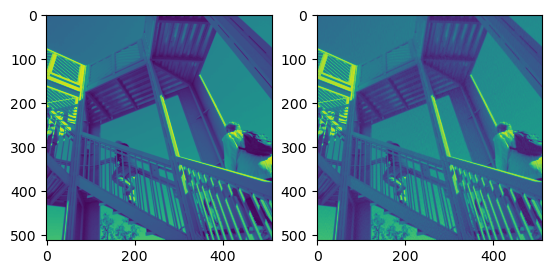

In [4]:
import numpy as np
from sklearn import linear_model
import scipy.misc
from matplotlib import pyplot as plt


class KSVD(object):
    def __init__(self, n_components, max_iter=30, tol=1e-6,
                 n_nonzero_coefs=None):
        """
        稀疏模型Y = DX，Y为样本矩阵，使用KSVD动态更新字典矩阵D和稀疏矩阵X
        :param n_components: 字典所含原子个数（字典的列数）
        :param max_iter: 最大迭代次数
        :param tol: 稀疏表示结果的容差
        :param n_nonzero_coefs: 稀疏度
        """
        self.dictionary = None
        self.sparsecode = None
        self.max_iter = max_iter
        self.tol = tol
        self.n_components = n_components
        self.n_nonzero_coefs = n_nonzero_coefs

    def _initialize(self, y):
        """
        初始化字典矩阵
        """
        u, s, v = np.linalg.svd(y)
        self.dictionary = u[:, :self.n_components]

    def _update_dict(self, y, d, x):
        """
        使用KSVD更新字典的过程
        """
        for i in range(self.n_components):
            index = np.nonzero(x[i, :])[0]
            if len(index) == 0:
                continue

            d[:, i] = 0
            r = (y - np.dot(d, x))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            d[:, i] = u[:, 0].T
            x[i, index] = s[0] * v[0, :]
        return d, x

    def fit(self, y):
        """
        KSVD迭代过程
        """
        self._initialize(y)
        for i in range(self.max_iter):
            x = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)
            e = np.linalg.norm(y - np.dot(self.dictionary, x))
            if e < self.tol:
                break
            self._update_dict(y, self.dictionary, x)

        self.sparsecode = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)
        return self.dictionary, self.sparsecode


if __name__ == '__main__':
    im_ascent = scipy.misc.ascent().astype(np.float)
    ksvd = KSVD(300)
    dictionary, sparsecode = ksvd.fit(im_ascent)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(im_ascent)
    plt.subplot(1, 2, 2)
    plt.imshow(dictionary.dot(sparsecode))
    plt.show()

## 库函数

https://github.com/nel215/ksvd

In [5]:
%%bash

pip install ksvd

In [35]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.datasets as datasets

# 加载CIFAR10数据集
cifar10 = datasets.MNIST(root='~/data', train=True, download=True)
# 选择一张图片
img, label = cifar10[0]
# 转换为numpy数组
img_array = np.array(img)

ksvd = ApproximateKSVD(n_components=32)
dictionary = ksvd.fit(img_array).components_
gamma = ksvd.transform(img_array)

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

In [36]:
dictionary.shape,gamma.shape

((32, 28), (28, 32))

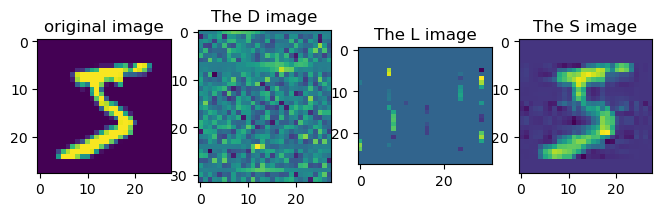

In [37]:
# 显示原始图片和压缩后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title('original image')
# plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(dictionary)
plt.title('The D image')
# plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(gamma)
plt.title('The L image')
# plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(gamma.dot(dictionary))
plt.title('The S image')
# plt.axis('off')
plt.show()

# PCA